## Bayesian rate consistency model with PriorCVAE


In [358]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp
import pyreadr
import pandas as pd
import os

from priorCVAE.models import MLPDecoder
from priorCVAE.priors import Matern32, Matern52
from priorCVAE.datasets import GPDataset
from priorCVAE.utility import load_model_params

import jax.config as config
config.update("jax_enable_x64", True)

In [359]:
# Configuration dictionary
args = {
        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,
        "batch_size": 500,
        "num_iterations": 5000,
        "data_dim": 2,
        "n_test": 5000,
        "kernel": "matern52",
        "ls": 0.2
       }
args['model_path'] = f"weights/vae_{args['input_dim']}_{args['num_iterations']}_{args['data_dim']}d_{args['kernel']}_{args['ls']}"

In [360]:
args['model_path'] = "weights/vae_1936_5000_2d_matern52_0.2"

## Generate data

In [361]:
kernel = Matern52(lengthscale=0.2)

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=False, data_dim=2)  
gp_set.reshape = False
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=args['batch_size'])
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

## Load the model


In [362]:
decoder_params = load_model_params(args["model_path"])["decoder"]

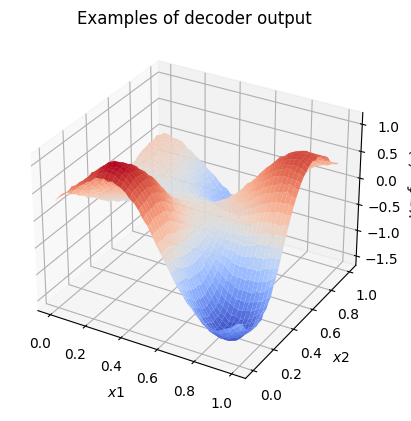

In [363]:
decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["n_test"], args["latent_dim"]))

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, e_rng, d_rng = jax.random.split(key, 3)

vae_samples = decoder.apply({'params': decoder_params}, z)             


vae_samples_reshaped = vae_samples.reshape((args["n_test"], gp_set.n_data, gp_set.n_data))

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})

ax.plot_surface(gp_set.x1, gp_set.x2, vae_samples_reshaped[40], cmap=coolwarm)

ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()

## Bayesian rate consistency model

In [364]:
datasets_dir = "/Users/eric/acse/irp/priorCVAE-bayes-rate-consistency/data/my_simulations/datasets"
data_dir = "inCOVID_2000_COVIMOD"
data_path = os.path.join(datasets_dir, data_dir, "data_1.rds")
data_path

'/Users/eric/acse/irp/priorCVAE-bayes-rate-consistency/data/my_simulations/datasets/inCOVID_2000_COVIMOD/data_1.rds'

### Load Data

In [365]:
data = pyreadr.read_r(data_path)[None]


In [366]:
def categorize_age_strata(data):
    age_order = ['6-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-49']
    # Convert the 'alter_age_strata' column to a categorical type with the custom order
    data['alter_age_strata'] = pd.Categorical(data['alter_age_strata'], categories=age_order, ordered=True)
    return data
data = categorize_age_strata(data)

In [367]:
data[(data['age'] == 6) & (data['alter_age'] == 6)]

,age,gender,alter_age,alter_gender,cntct_intensity,cntct_rate,pop,alter_age_strata,part,mu,y,y_strata,cntct_intensity_strata,pop_strata,cntct_rate_strata
0,6,Female,6,Female,0.038971,1.137047e-07,342735,6-9,16.0,1.0,1,2,0.164349,1758888,9.343923e-08
1,6,Female,6,Male,0.041029,1.137047e-07,360842,6-9,16.0,1.0,0,2,0.173136,1852932,9.343909e-08
88,6,Male,6,Female,0.038971,1.137047e-07,342735,6-9,17.0,1.0,1,1,0.160704,1758888,9.136674e-08
89,6,Male,6,Male,0.041029,1.137047e-07,360842,6-9,17.0,1.0,1,4,0.173136,1852932,9.343909e-08


In [368]:
from sim_make_mcmc_data import make_mcmc_data

A = 44
strata_scheme = 'COVIMOD'

In [369]:
mcmc_data = make_mcmc_data(data, A, strata_scheme)

In [370]:
mcmc_data.keys()
mcmc_data['P_M']

Array([360842, 362708, 365337, 375297, 388748, 399022, 401939, 412448,
       418822, 399449, 393827, 401947, 423774, 437937, 480578, 491485,
       498135, 502705, 490874, 481129, 483314, 486336, 501166, 503461,
       497543, 484755, 469921, 472159, 460453, 449580, 451267, 456308,
       478102, 542188, 574280, 608365, 652906, 680638, 692524, 708462,
       719189, 725438, 706502, 686821], dtype=int32)

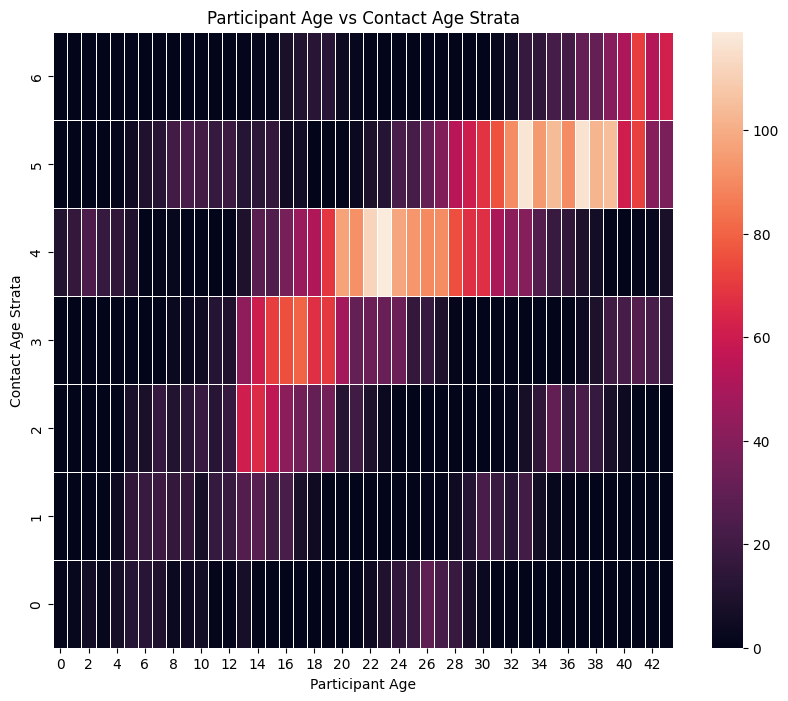

In [371]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(10,8))  # Set the figure size
sns.heatmap(mcmc_data['Y_MF'].T, annot=False, fmt="d", linewidths=.5)

# Customize the plot
plt.title('Participant Age vs Contact Age Strata')
plt.xlabel('Participant Age')
plt.ylabel('Contact Age Strata')

plt.gca().invert_yaxis()

# Display the plot
plt.show()


## MCMC Inference

In [542]:

args = {
        # architecture
        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 2000,
        "num_chains": 4,
        "thinning": 1,
       }

In [742]:
args['logP'] = mcmc_data['log_P_F']
args['logN'] = mcmc_data['log_N_M']
args['z_dim'] = 30
args['map_age_to_strata'] = mcmc_data['map_age_to_strata']
args['Y'] = mcmc_data['Y_MF']

# 1e-13

In [743]:
import numpyro.distributions as dist

        
def contact_mcmc_inference_model(args, decoder, decoder_params, y = None, c: jnp.array = None):
    
    y = args['Y']
    log_P = args['logP']
    log_N = args['logN']
    z_dim = args['z_dim']
    map_age_to_strata = args['map_age_to_strata']
    
    epsilon = 1e-13

    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))  # (Z_dim,)
    f = numpyro.deterministic("f", decoder.apply({'params': decoder_params}, z))
    f = jnp.reshape(f, (44,44))
    
    #fixed effects
    beta_0 = numpyro.sample('beta_0', dist.Normal(0, 10))
    v = numpyro.sample('v', dist.Exponential(1))
    # tau = numpyro.sample('tau', dist.Normal(0, 1))
    rho = numpyro.sample('rho', dist.Normal(0, 1))

    log_contact_rate = numpyro.deterministic("log_contact_rate", beta_0 + f)
    log_m = log_contact_rate + log_P
    log_mu = log_m + log_N + rho
    mu = jnp.exp(log_mu)
    mapped_mu = jnp.matmul(mu, map_age_to_strata)
    alpha = mapped_mu/(v/(1+v)) + epsilon

    if y is None:
        numpyro.sample("yhat_strata", dist.GammaPoisson(alpha, 1/v))
    else:
        numpyro.sample("y_strata", dist.GammaPoisson(alpha, 1/v), obs=y)

In [744]:
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
import time

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

args['Y'] = mcmc_data['Y_MF']

# inference
start = time.time()
kernel = NUTS(contact_mcmc_inference_model)
mcmc_vae = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains = 1, thinning = 1)
mcmc_vae.run(rng_key, args, decoder, decoder_params),
t_elapsed = time.time() - start

prev_samples = mcmc_vae.get_samples()

sample: 100%|██████████| 1500/1500 [00:43<00:00, 34.59it/s, 127 steps of size 3.55e-02. acc. prob=0.95]


In [745]:
# mcmc_vae.print_summary(exclude_deterministic = False)

In [746]:
# from priorCVAE.mcmc import run_mcmc_vae

# rng_key_draw =  random.PRNGKey(1)
# rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

# mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, contact_mcmc_inference_model, args, decoder, 
#                                                      decoder_params)

In [747]:
import arviz as az
samples_vae_az = az.from_numpyro(mcmc_vae)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

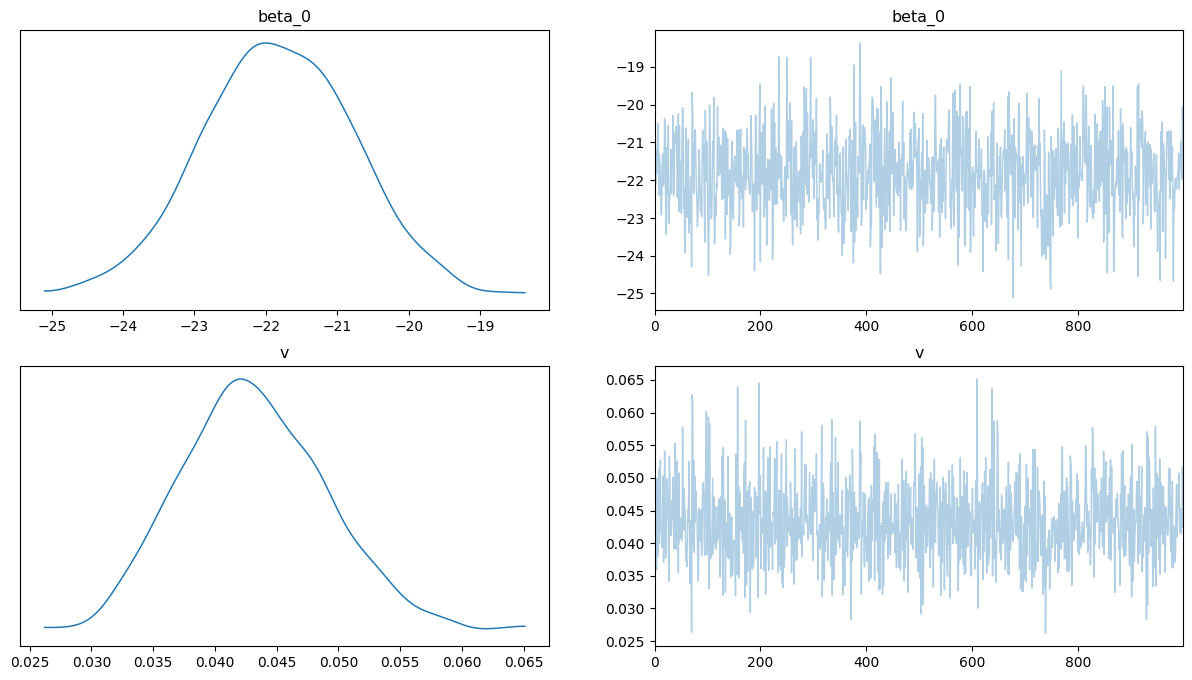

In [748]:
az.plot_trace(samples_vae_az, var_names = ("beta_0", "v"), figsize = (15, 8))

### Posterior predictive checks

In [749]:
args['Y'] = None
predictive = Predictive(contact_mcmc_inference_model, samples)
predictions_vae = predictive(rng_key_predict, args, decoder, decoder_params)

In [750]:
y_strata = mcmc_data['Y_MF']
yhat_strata = np.mean(predictions_vae['yhat_strata'],axis=0)

In [751]:
np.mean(np.abs(y_strata_pred-y_strata))

11.758116883116884

In [752]:
jnp.quantile(predictions_vae['yhat_strata'], 0.975, axis=0).sum()

Array(0., dtype=float64)

In [753]:
def sim_posterior_predictive_check(predictions, mcmc_data):
    y_strata = mcmc_data['Y_MF']
    yhat_strata = predictions['yhat_strata']

    ci_lower = jnp.quantile(yhat_strata, 0.025, axis=0)
    ci_upper = np.quantile(yhat_strata, 0.975, axis=0)
    in_range = (ci_lower <= y_strata) & (y_strata <= ci_upper)
    valid_idx = np.where(in_range)
    proportion = valid_idx[0].shape[0]/y_strata.size
    return proportion

sim_posterior_predictive_check(predictions_vae, mcmc_data)

0.33766233766233766

### Recover contact instensities

In [754]:
posterior_samples = mcmc_vae.get_samples().copy()
P = mcmc_data['P_F']
P = np.tile(P, (44, 1))
beta_0 = posterior_samples['beta_0']
f = posterior_samples['f']

m_pred = jnp.exp(jnp.quantile(beta_0[1, jnp.newaxis] + f, 0.5, axis=0)).reshape(44,44) * P
# jnp.exp(beta_0[1, jnp.newaxis] + f)
log_contact_rate = posterior_samples['log_contact_rate']

m_pred = jnp.exp(jnp.quantile(log_contact_rate, 0.5, axis=0)).reshape(44,44) * P

In [755]:
posterior_samples.keys()
predictions_vae.keys()

dict_keys(['f', 'log_contact_rate', 'yhat_strata'])

In [760]:
v = jnp.quantile(posterior_samples['v'], 0.5, axis=0)
log_rate = jnp.quantile(log_contact_rate, 0.5, axis=0)
log_m = log_rate + mcmc_data['log_P_F']
log_mu = log_m + mcmc_data['log_N_M']
mu = jnp.exp(log_mu)
mapped_mu = jnp.matmul(mu, mcmc_data['map_age_to_strata'])
mapped_mu
alpha = mapped_mu/(v/(1+v)) + 1e-13#+ epsilon
gamma_poisson = dist.GammaPoisson(alpha, 1/v)
print(alpha)
key = jax.random.PRNGKey(0)

# Sample from the distribution
sample = gamma_poisson.sample(key, sample_shape=(1,))
sample


[[0.20980401 0.27932426 0.25411756 0.2509427  0.32605105 0.1984839
  0.13403867]
 [0.21641417 0.28924745 0.27292104 0.26607053 0.32883324 0.18046776
  0.11804552]
 [0.22488387 0.30693032 0.2911478  0.28151749 0.34007837 0.16838518
  0.10767798]
 [0.23892106 0.33543947 0.32071524 0.30575854 0.36311037 0.1573454
  0.09729794]
 [0.26564184 0.3886513  0.37541782 0.36157599 0.42204518 0.16268707
  0.09529141]
 [0.28734931 0.42353841 0.42362139 0.41018165 0.46408749 0.16073121
  0.09081838]
 [0.3240323  0.48823498 0.49710301 0.50082147 0.55509702 0.17255521
  0.09259268]
 [0.33447872 0.53386831 0.55921294 0.56884151 0.63397885 0.18022681
  0.09021112]
 [0.35390966 0.59320202 0.62819001 0.66915241 0.72744282 0.19119251
  0.08851163]
 [0.36928472 0.59643737 0.66552875 0.74171753 0.80595111 0.19755386
  0.0852379 ]
 [0.38814825 0.64629092 0.75833131 0.86192358 0.93270779 0.22058935
  0.08824065]
 [0.42984572 0.7421809  0.88229271 1.05797778 1.15279328 0.26025166
  0.09678622]
 [0.47367093 0.836

Array([[[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        

In [758]:
m = data[
    (data['gender'] == 'Male') & 
    (data['alter_gender'] == 'Female')
].sort_values(by=['age', 'alter_age']).cntct_intensity.to_numpy().reshape(44,44)

In [759]:
mae = np.mean(np.abs(m - m_pred))
mae

0.12385472113223636

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Simulated intensities'}>)

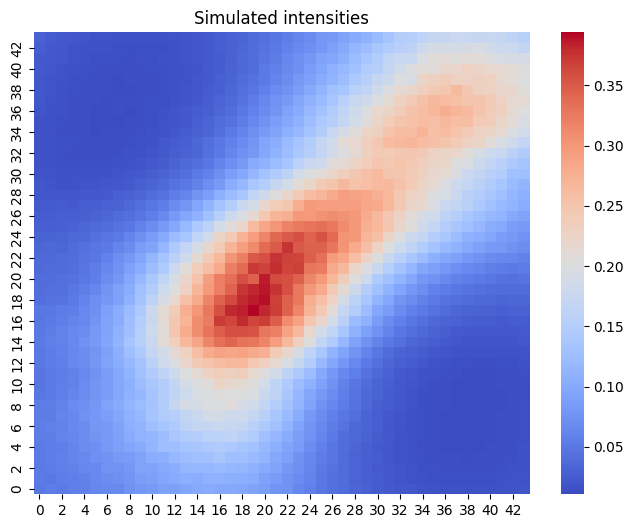

In [654]:
def plot_heatmap(matrix: jnp.ndarray, title='', figsize=(8,6)):
    """ Plot a heatmap of the input matrix. """

    # matrix[0, 42:44] = 100
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.heatmap(matrix, annot=False, fmt='g', cmap='coolwarm', ax=ax)
    ax.set_title(title)
    plt.gca().invert_yaxis()
    return fig, ax

plot_heatmap(m_pred.T, title='Simulated intensities')